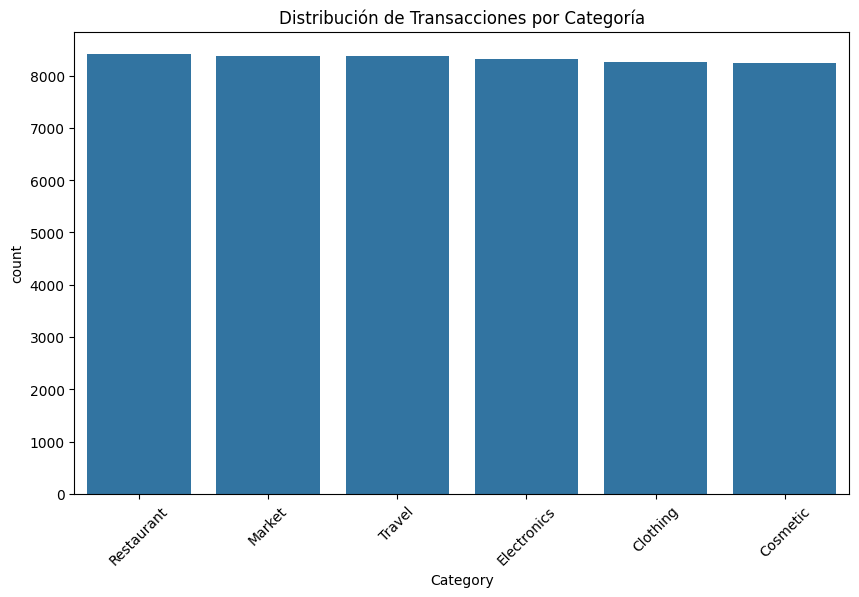

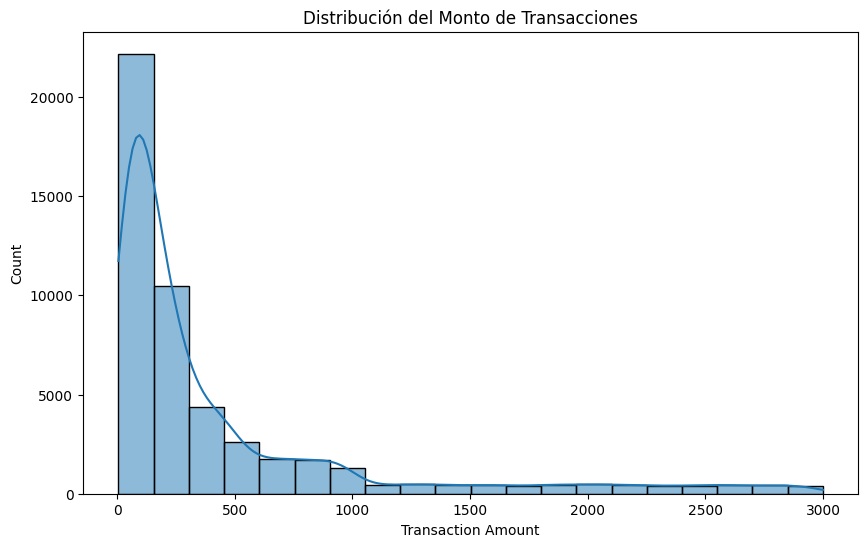

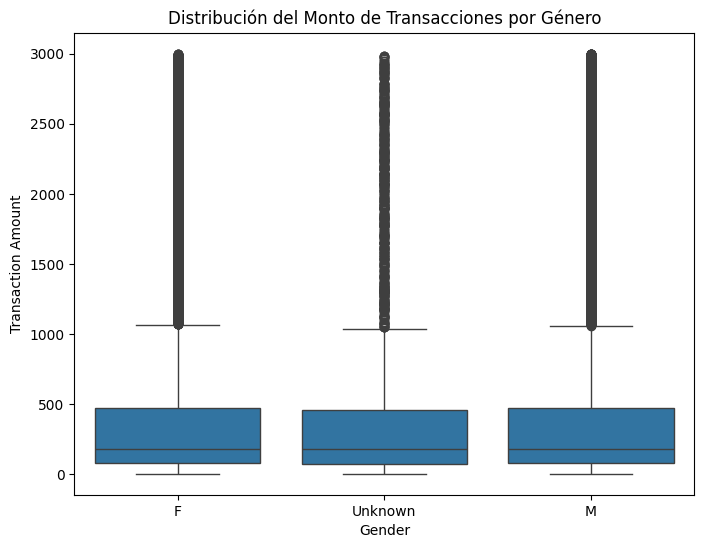

   Customer ID      Name    Surname  Gender   Birthdate  Transaction Amount  \
0       752858      Sean  Rodriguez       0  2002-10-20               35.47   
1        26381  Michelle     Phelps       2  1985-10-24             2552.72   
2       305449     Jacob   Williams       1  1981-10-25              115.97   
3       988259    Nathan     Snyder       1  1977-10-26               11.31   
4       764762   Crystal      Knapp       0  1951-11-02               62.21   

         Date          Merchant Name  Category_Cosmetic  Category_Electronics  \
0  2023-04-03           smithrussell               True                 False   
1  2023-07-17      peck spence young              False                 False   
2  2023-09-20             steele inc              False                 False   
3  2023-01-11  wilson wilson russell               True                 False   
4  2023-06-13           palmerhinton              False                  True   

   ...  turner  walker  ward  watson  

In [12]:
# Importaciones
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Descargar stopwords y el lematizador de NLTK si no están disponibles
# nltk.download('stopwords')
# nltk.download('wordnet')

# Cargar datos
data = pd.read_csv('../transaction-data/sample_dataset.csv')

# Eliminar duplicados
data.drop_duplicates(inplace=True)

# Llenamos los géneros con "Unknown" y rellenamos valores nulos en 'Transaction Amount' con la mediana
data['Gender'] = data['Gender'].fillna('Unknown')
data['Transaction Amount'] = data['Transaction Amount'].fillna(data['Transaction Amount'].median())

# Rellenar valores nulos restantes en otras columnas con un valor genérico
data.fillna('N/A', inplace=True)

# Confirmando que no queden valores nulos
data.isnull().sum()

# Análisis exploratorio: Estadísticas descriptivas de datos numéricos
data.describe()

# Graficos
# Distribución de la cantidad de transacciones por categoría de producto
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Category', order=data['Category'].value_counts().index)
plt.title("Distribución de Transacciones por Categoría")
plt.xticks(rotation=45)
plt.show()

# Análisis de distribución de 'Transaction Amount'
plt.figure(figsize=(10, 6))
sns.histplot(data['Transaction Amount'], bins=20, kde=True)
plt.title("Distribución del Monto de Transacciones")
plt.show()

# Relación entre 'Transaction Amount' y 'Gender'
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Gender', y='Transaction Amount')
plt.title("Distribución del Monto de Transacciones por Género")
plt.show()

# Codificación de 'Gender' y 'Category'
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])
data = pd.get_dummies(data, columns=['Category'], drop_first=True)

# Preprocesamiento de texto para la columna 'Merchant Name'
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenización y eliminación de palabras vacías
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lematización
    words = [lemmatizer.lemmatize(word) for word in words]
    # Unir palabras procesadas en un solo string
    return " ".join(words)

# Aplicar la función de preprocesamiento a la columna 'Merchant Name'
data['Merchant Name'] = data['Merchant Name'].apply(preprocess_text)

# Transformación con TF-IDF
# Ajusta el número de características según sea necesario
tfidf_vectorizer = TfidfVectorizer(max_features=100)  
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Merchant Name'])

# Convertir la matriz TF-IDF a un DataFrame y unirla al conjunto de datos original
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
data = pd.concat([data, tfidf_df], axis=1)

# Verificar informacion final
print(data.head())

# Crear matriz de similitud
similarity_matrix = cosine_similarity(tfidf_matrix)

# Función para obtener recomendaciones y metricas relevantes
def get_recommendations(customer_id, top_n=5):
    user_data = data[data['Customer ID'] == customer_id]
    if user_data.empty:
        return None  

    user_transactions = user_data['Merchant Name'].values
    if len(user_transactions) == 0:
        return None  

    indices = [data[data['Merchant Name'] == name].index[0] for name in user_transactions if name in data['Merchant Name'].values]
    avg_similarity = similarity_matrix[indices].mean(axis=0)

    recommended_indices = avg_similarity.argsort()[-top_n:][::-1]
    recommended_items = data.iloc[recommended_indices][['Merchant Name', 'Transaction Amount']]
    
    return recommended_items

# Evaluar el modelo
def evaluate_model(test_data):
    y_true = test_data['Transaction Amount']
    y_pred = []

    for customer_id in test_data['Customer ID']:
        recommendations = get_recommendations(customer_id, top_n=5)
        if recommendations is not None:
            y_pred.append(recommendations['Transaction Amount'].mean())  # Promedio de montos recomendados
        else:
            y_pred.append(np.nan)  # Si no hay recomendaciones, añadir NaN
    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # (Root mean square deviation)Distancia media cuadrática mínima
    print(f"RMSE del modelo: {rmse}")

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Evaluar el modelo 
evaluate_model(test_data)

